In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
base_dir = r'C:\Users\I\Desktop\Neural networks\Neural network data\Case3'
glove_dir = os.path.join(base_dir, 'glove.6B')
dataTrain = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTrain_raw.csv')
dataTest = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTest_raw.csv')

In [3]:
# Tokenize the text
samples = dataTrain['review']
samplesTest = dataTest['review']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)
tokenizer.fit_on_texts(samplesTest)
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)
sequencesTest = tokenizer.texts_to_sequences(samplesTest)

word_index = tokenizer.word_index

print('Found %s unique tokens in train data.' % len(word_index))

#pad sequences
Data = pad_sequences(sequences, maxlen=200)
DataTest = pad_sequences(sequencesTest, maxlen=200)

Found 55245 unique tokens in train data.


In [4]:
# Create six categories for train and testing 
# label = 5, when rating == 10
# label = 4, when rating = 8-9
# label = 3, when rating = 6-7
# label = 2, when rating = 4-5
# label = 1, when rating = 2-3
# label = 0, when rating == 1
Labels = dataTrain['rating'].values
for i in range(len(Labels)):
    x = Labels[i]
    if x == 10:
        Labels[i] = 5
    elif x >= 8:
        Labels[i] = 4
    elif x >= 6:
        Labels[i] = 3
    elif x >= 4:
        Labels[i] = 2
    elif x >= 2:    
        Labels[i] = 1
    else:
        Labels[i] = 0

LabelsTest = dataTest['rating'].values
for i in range(len(LabelsTest)):
    x = LabelsTest[i]
    if x == 10:
        LabelsTest[i] = 5
    elif x >= 8:
        LabelsTest[i] = 4
    elif x >= 6:
        LabelsTest[i] = 3
    elif x >= 4:
        LabelsTest[i] = 2
    elif x >= 2:    
        LabelsTest[i] = 1
    else:
        LabelsTest[i] = 0        

In [5]:
Labels = to_categorical(np.asarray(Labels))
LabelsTest = to_categorical(np.asarray(LabelsTest))
print('Shape of train data tensor:', Data.shape)
print('Shape of train label tensor:', Labels.shape)
print('Shape of test data tensor:', DataTest.shape)
print('Shape of test label tensor:', LabelsTest.shape)

Shape of train data tensor: (161297, 200)
Shape of train label tensor: (161297, 6)
Shape of test data tensor: (53766, 200)
Shape of test label tensor: (53766, 6)


In [6]:
validation_split = 0.3

# split the data into a training set and a validation set
indices = np.arange(Data.shape[0])
np.random.shuffle(indices)
Data = Data[indices]
Labels = Labels[indices]
nb_validation_samples = int(validation_split * Data.shape[0])

x_train = Data[:-nb_validation_samples]
y_train = Labels[:-nb_validation_samples]
x_validation = Data[-nb_validation_samples:]
y_validation = Labels[-nb_validation_samples:]

In [7]:
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
        
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Since glove.6B.200d embedding_matrix = np.zeros((num_words, 200)) and output in Embedding is also 200.

In [8]:
num_words = min(5000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 200))
for word, i in word_index.items():
    if i >= 5000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [9]:
embedding_layer = Embedding(num_words,
                            200,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

In [10]:
sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(6, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [11]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_validation, y_validation))

Train on 112908 samples, validate on 48389 samples
Epoch 1/10
112908/112908 [==============================] - 84s 742us/sample - loss: 1.4401 - acc: 0.4071 - val_loss: 1.4342 - val_acc: 0.4215
Epoch 2/10
112908/112908 [==============================] - 79s 698us/sample - loss: 1.2588 - acc: 0.4782 - val_loss: 1.2404 - val_acc: 0.4850
Epoch 3/10
112908/112908 [==============================] - 71s 631us/sample - loss: 1.1618 - acc: 0.5160 - val_loss: 1.2033 - val_acc: 0.4986
Epoch 4/10
112908/112908 [==============================] - 77s 680us/sample - loss: 1.0762 - acc: 0.5512 - val_loss: 1.6414 - val_acc: 0.4624
Epoch 5/10
112908/112908 [==============================] - 82s 728us/sample - loss: 0.9850 - acc: 0.5919 - val_loss: 1.2837 - val_acc: 0.4913
Epoch 6/10
112908/112908 [==============================] - 81s 720us/sample - loss: 0.8919 - acc: 0.6357 - val_loss: 1.3035 - val_acc: 0.5251
Epoch 7/10
112908/112908 [==============================] - 80s 713us/sample - loss: 0.8034

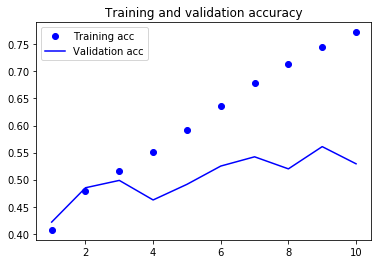

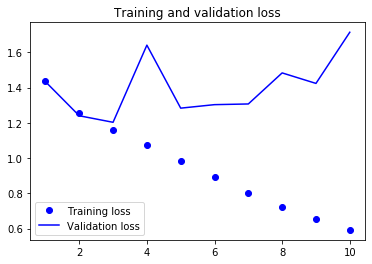

<Figure size 432x288 with 0 Axes>

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

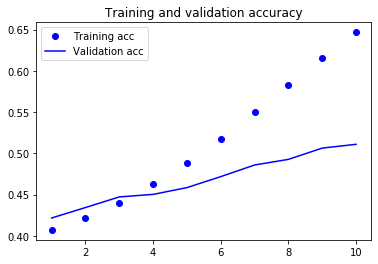

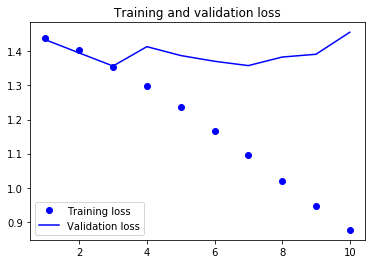

<Figure size 432x288 with 0 Axes>

In [17]:
epochs = range(1, len(acc) + 1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

In [18]:
# Find the predicted values for the validation set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 3908   746   265   159   160   160]
 [ 1017  1711   459   211   186   102]
 [  577   692  1610   526   358   164]
 [  218   282   463  1251   464   166]
 [  367   408   669  1309  4680  1352]
 [ 1212   700   903  1754  9485 15072]]
              precision    recall  f1-score   support

           0       0.72      0.54      0.62      7299
           1       0.46      0.38      0.42      4539
           2       0.41      0.37      0.39      4369
           3       0.44      0.24      0.31      5210
           4       0.53      0.31      0.39     15333
           5       0.52      0.89      0.65     17016

    accuracy                           0.53     53766
   macro avg       0.51      0.45      0.46     53766
weighted avg       0.53      0.53      0.50     53766



In [19]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.368
Cohen's kappa (quadratic) = 0.687


As can be seen from the graphs above the models preformance isn't going up at all with pre-trained word embedding globe.6B. Its waste of time to computed model with 3 epochs and train with all training data.

Trainable word embedding in case 3, seems to be the best option.